In [3]:
!pip install bert_score 

In [4]:
!pip install rouge_score

In [3]:
pip install transformers --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 88.9 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.1
    Uninstalling transformers-4.51.1:
      Successfully uninstalled transformers-4.51.1
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
from datasets import Dataset, load_from_disk

# here are directory of the dataset 
TRAIN_DIR = "/kaggle/input/filedataset2/data/therapy_train"
VAL_DIR = "/kaggle/input/filedataset2/data/therapy_val"
TEST_DIR = "/kaggle/input/filedataset2/data/therapy_test"

def load_arrow_split(split_dir):

    try:
        dataset = load_from_disk(split_dir)

        input_texts = dataset["input_text"]
        target_texts = dataset["target_text"]

        print(f"Loaded {len(dataset)} samples from {split_dir}")
        return input_texts, target_texts

    except Exception as e:
        print(f"Error loading {split_dir}: {e}")
        print("Using fallback sample data instead...")

        sample_input_texts = [
            "T: Hi you how to do it today? [SEP] P: Great. How are you? [SEP] T: I'm doing well. Thanks for asking.",
            "T: What brings you in today? [SEP] P: I've been feeling anxious lately. [SEP] T: I'm sorry to hear that.",
            "T: Have you noticed any triggers for your anxiety? [SEP] P: Work has been stressful. [SEP] T: That sounds challenging."
        ]
        sample_target_texts = [
            "So you're doing great.",
            "Can you tell me more about your anxiety?",
            "How has work been stressful for you?"
        ]

        return sample_input_texts, sample_target_texts


def load_arrow_data():

    os.makedirs("./logs", exist_ok=True)
    os.makedirs("./bart_finetuned", exist_ok=True)

    print("Loading datasets...")
    train_inputs, train_targets = load_arrow_split(TRAIN_DIR)
    val_inputs, val_targets = load_arrow_split(VAL_DIR)
    test_inputs, test_targets = load_arrow_split(TEST_DIR)

    print("\nSample training examples:")
    for i in range(min(3, len(train_inputs))):
        print(f"\nInput: {train_inputs[i]}")
        print(f"Target: {train_targets[i]}")

    return train_inputs, train_targets, val_inputs, val_targets, test_inputs, test_targets


In [7]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import BartTokenizer, BartForConditionalGeneration
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
import re
from sklearn.model_selection import train_test_split
from tqdm import tqdm


try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# random seed for reproducibility here we see our rollno 
torch.manual_seed(2022418)
np.random.seed(2022418)


MAX_SOURCE_LENGTH = 512
MAX_TARGET_LENGTH = 128
BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

2025-04-15 14:43:52.803327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744728232.974985      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744728233.022807      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [9]:
class CounselingDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_source_len, max_target_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_source_len = max_source_len
        self.max_target_len = max_target_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        target = str(self.targets[idx])
        
        source_encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_source_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        
        target_encoding = self.tokenizer.encode_plus(
            target,
            max_length=self.max_target_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        
        input_ids = source_encoding["input_ids"].squeeze()
        attention_mask = source_encoding["attention_mask"].squeeze()
        labels = target_encoding["input_ids"].squeeze()

        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }

In [10]:
def load_data(file_path):

    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded data from {file_path}")
        print(f"Data shape: {df.shape}")
        
 
        if 'input_text' in df.columns and 'target_text' in df.columns:
            input_texts = df['input_text'].tolist()
            target_texts = df['target_text'].tolist()
        else:

            text_columns = [col for col in df.columns if 'text' in col.lower() or 'utterance' in col.lower()]
            if len(text_columns) >= 2:
                input_texts = df[text_columns[0]].tolist()
                target_texts = df[text_columns[1]].tolist()
            else:
                raise ValueError("Could not identify input and target text columns")
        
        return input_texts, target_texts
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Using sample data instead")
        input_texts = [
            "T: Hi you how to do it today? [SEP] P: Great. How are you? [SEP] T: I'm doing well. Thanks for asking.",
            "T: What brings you in today? [SEP] P: I've been feeling anxious lately. [SEP] T: I'm sorry to hear that.",
            "T: Have you noticed any triggers for your anxiety? [SEP] P: Work has been stressful. [SEP] T: That sounds challenging."
        ]
        target_texts = [
            "So you're doing great.",
            "Can you tell me more about your anxiety?",
            "How has work been stressful for you?"
        ]
        return input_texts, target_texts


In [11]:
def calculate_bleu(reference, candidate):

    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())
    
    references = [reference_tokens]

    smoothie = SmoothingFunction().method1
    
    try:
        bleu_score = sentence_bleu(references, candidate_tokens, smoothing_function=smoothie)
        return bleu_score
    except Exception as e:
        print(f"Error calculating BLEU score: {e}")
        return 0.0


def calculate_bert_similarity(text1, text2, model, tokenizer):

    inputs1 = tokenizer(text1, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
    inputs2 = tokenizer(text2, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
    
    with torch.no_grad():
       
        outputs1 = model(**inputs1, output_hidden_states=True)
        outputs2 = model(**inputs2, output_hidden_states=True)

        embeddings1 = outputs1.hidden_states[-1].mean(dim=1)
        embeddings2 = outputs2.hidden_states[-1].mean(dim=1)

        embeddings1 = embeddings1 / embeddings1.norm(dim=1, keepdim=True)
        embeddings2 = embeddings2 / embeddings2.norm(dim=1, keepdim=True)
        similarity = torch.matmul(embeddings1, embeddings2.transpose(0, 1)).item()
        
    return similarity


In [12]:
def train_model(model, tokenizer, train_loader, val_loader, num_epochs, learning_rate=5e-5):

    model.to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    best_val_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")

        for batch in progress_bar:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            progress_bar.set_postfix({"loss": loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)


        model.eval()
        total_val_loss = 0
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")

        with torch.no_grad():
            for batch in progress_bar:
                input_ids = batch["input_ids"].to(DEVICE)
                attention_mask = batch["attention_mask"].to(DEVICE)
                labels = batch["labels"].to(DEVICE)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()
                progress_bar.set_postfix({"loss": loss.item()})

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f"best_{model.__class__.__name__.lower()}_model.pt")
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")

    return model, val_losses, train_losses


In [14]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [15]:
import evaluate

def generate_and_evaluate(model, tokenizer, test_loader, model_name):

    model.to(DEVICE)
    model.eval()
    
    all_preds = []
    all_refs = []
    bleu_scores = []
    
    bertscore = evaluate.load("bertscore")
    
    for batch in tqdm(test_loader, desc=f"Generating predictions with {model_name}"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        
        target_ids = torch.where(labels == -100, tokenizer.pad_token_id, labels)
        
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=MAX_TARGET_LENGTH,
                num_beams=4,
                early_stopping=True
            )

        preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        refs = tokenizer.batch_decode(target_ids, skip_special_tokens=True)
        

        for pred, ref in zip(preds, refs):
            bleu = calculate_bleu(ref, pred)
            bleu_scores.append(bleu)
            
        all_preds.extend(preds)
        all_refs.extend(refs)
    
    bertscore_results = bertscore.compute(
        predictions=all_preds, 
        references=all_refs, 
        lang="en",
        device=DEVICE
    )
    
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
    avg_bert_precision = sum(bertscore_results['precision']) / len(bertscore_results['precision'])
    avg_bert_recall = sum(bertscore_results['recall']) / len(bertscore_results['recall'])
    avg_bert_f1 = sum(bertscore_results['f1']) / len(bertscore_results['f1'])
    
    print(f"\n{model_name} Results:")
    print(f"Average BLEU score: {avg_bleu:.4f}")
    print(f"Average BERTScore Precision: {avg_bert_precision:.4f}")
    print(f"Average BERTScore Recall: {avg_bert_recall:.4f}")
    print(f"Average BERTScore F1: {avg_bert_f1:.4f}")

    for i in range(min(2, len(all_preds))):
        print(f"\nExample {i+1}:")
        print(f"Reference: {all_refs[i]}")
        print(f"Prediction: {all_preds[i]}")
        print(f"BLEU score: {bleu_scores[i]:.4f}")
        print(f"BERTScore F1: {bertscore_results['f1'][i]:.4f}")
    
    return all_preds, all_refs, bleu_scores, bertscore_results

In [30]:
train_texts, train_targets,val_texts, val_targets,test_texts, test_targets = load_arrow_data()
    
print(f"Train set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")
print(f"Test set size: {len(test_texts)}")
    

print("\nInitializing T5 model and tokenizer...")
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")
    

print("Preparing T5 datasets...")
t5_train_dataset = CounselingDataset(
    train_texts, train_targets, t5_tokenizer, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH
)
t5_val_dataset = CounselingDataset(
    val_texts, val_targets, t5_tokenizer, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH
)
t5_test_dataset = CounselingDataset(
    test_texts, test_targets, t5_tokenizer, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH
)
    

t5_train_loader = DataLoader(t5_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
t5_val_loader = DataLoader(t5_val_dataset, batch_size=BATCH_SIZE)
t5_test_loader = DataLoader(t5_test_dataset, batch_size=BATCH_SIZE)



Loading datasets...
Loaded 4008 samples from /kaggle/input/filedataset2/data/therapy_train
Loaded 576 samples from /kaggle/input/filedataset2/data/therapy_val
Loaded 968 samples from /kaggle/input/filedataset2/data/therapy_test

Sample training examples:

Input: T: Hi you how to do it today? [SEP] P: Great. How are you?
Target: I'm doing well. Thanks for asking.

Input: T: Hi you how to do it today? [SEP] P: Great. How are you? [SEP] T: I'm doing well. Thanks for asking.
Target: So you're doing great.

Input: T: Hi you how to do it today? [SEP] P: Great. How are you? [SEP] T: I'm doing well. Thanks for asking. [SEP] T: So you're doing great. [SEP] P: I'm doing awesome.
Target: I know your brother brought you in today and he had expressed some concerns about your mood. Do you know what that's about?
Train set size: 4008
Validation set size: 576
Test set size: 968

Initializing T5 model and tokenizer...
Preparing T5 datasets...


In [33]:

print("\nTraining T5 model...")
t5_model,val_loss, train_loss = train_model(t5_model, t5_tokenizer, t5_train_loader, t5_val_loader, NUM_EPOCHS)


Training T5 model...


Epoch 1/10 [Validation]: 100%|██████████| 72/72 [00:07<00:00,  9.64it/s, loss=2.88]


Epoch 1: Train Loss = 3.5208, Val Loss = 3.3132
Saved best model with validation loss: 3.3132


Epoch 2/10 [Validation]: 100%|██████████| 72/72 [00:07<00:00,  9.61it/s, loss=2.85]


Epoch 2: Train Loss = 3.4220, Val Loss = 3.2765
Saved best model with validation loss: 3.2765


Epoch 3/10 [Validation]: 100%|██████████| 72/72 [00:07<00:00,  9.62it/s, loss=2.85]


Epoch 3: Train Loss = 3.3567, Val Loss = 3.2568
Saved best model with validation loss: 3.2568


Epoch 4/10 [Validation]: 100%|██████████| 72/72 [00:07<00:00,  9.53it/s, loss=2.84]


Epoch 4: Train Loss = 3.3086, Val Loss = 3.2451
Saved best model with validation loss: 3.2451


Epoch 5/10 [Validation]: 100%|██████████| 72/72 [00:07<00:00,  9.50it/s, loss=2.82]


Epoch 5: Train Loss = 3.2502, Val Loss = 3.2338
Saved best model with validation loss: 3.2338


Epoch 6/10 [Validation]: 100%|██████████| 72/72 [00:07<00:00,  9.64it/s, loss=2.84]


Epoch 6: Train Loss = 3.2193, Val Loss = 3.2289
Saved best model with validation loss: 3.2289


Epoch 7/10 [Validation]: 100%|██████████| 72/72 [00:07<00:00,  9.62it/s, loss=2.82]


Epoch 7: Train Loss = 3.1805, Val Loss = 3.2221
Saved best model with validation loss: 3.2221


Epoch 8/10 [Validation]: 100%|██████████| 72/72 [00:07<00:00,  9.63it/s, loss=2.82]


Epoch 8: Train Loss = 3.1433, Val Loss = 3.2195
Saved best model with validation loss: 3.2195


Epoch 9/10 [Validation]: 100%|██████████| 72/72 [00:07<00:00,  9.67it/s, loss=2.81]


Epoch 9: Train Loss = 3.1014, Val Loss = 3.2161
Saved best model with validation loss: 3.2161


Epoch 10/10 [Validation]: 100%|██████████| 72/72 [00:07<00:00,  9.60it/s, loss=2.8] 

Epoch 10: Train Loss = 3.0685, Val Loss = 3.2171


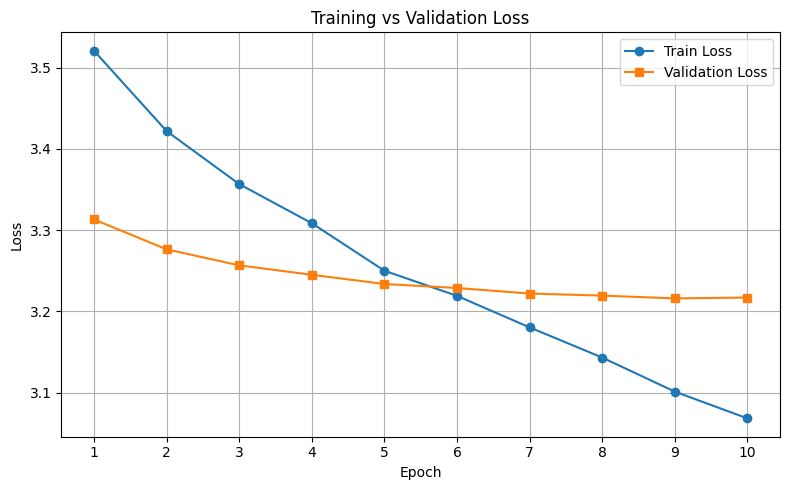

In [36]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
    
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss_curves(train_loss, val_loss)


In [37]:
print("\nInitializing BART model and tokenizer...")
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

print("Preparing BART datasets...")
bart_train_dataset = CounselingDataset(
    train_texts, train_targets, bart_tokenizer, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH
)
bart_val_dataset = CounselingDataset(
    val_texts, val_targets, bart_tokenizer, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH
)
bart_test_dataset = CounselingDataset(
    test_texts, test_targets, bart_tokenizer, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH
)

bart_train_loader = DataLoader(bart_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
bart_val_loader = DataLoader(bart_val_dataset, batch_size=BATCH_SIZE)
bart_test_loader = DataLoader(bart_test_dataset, batch_size=BATCH_SIZE)


Initializing BART model and tokenizer...
Preparing BART datasets...


In [38]:
print("\nTraining BART model...")
bart_model,val_loss_bart, train_loss_bart = train_model(bart_model, bart_tokenizer, bart_train_loader, bart_val_loader, NUM_EPOCHS)


Training BART model...


Epoch 1/10 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.36it/s, loss=2.46]


Epoch 1: Train Loss = 3.3620, Val Loss = 3.0977
Saved best model with validation loss: 3.0977


Epoch 2/10 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.42it/s, loss=2.5] 


Epoch 2: Train Loss = 2.9781, Val Loss = 3.0836
Saved best model with validation loss: 3.0836


Epoch 3/10 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.41it/s, loss=2.61]


Epoch 3: Train Loss = 2.7283, Val Loss = 3.1292


Epoch 4/10 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.37it/s, loss=2.67]


Epoch 4: Train Loss = 2.5129, Val Loss = 3.1808


Epoch 5/10 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.38it/s, loss=2.79]


Epoch 5: Train Loss = 2.2932, Val Loss = 3.2927


Epoch 6/10 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.39it/s, loss=2.82]


Epoch 6: Train Loss = 2.1031, Val Loss = 3.3562


Epoch 7/10 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.40it/s, loss=2.87]


Epoch 7: Train Loss = 1.9111, Val Loss = 3.4732


Epoch 8/10 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.41it/s, loss=3.18]


Epoch 8: Train Loss = 1.7342, Val Loss = 3.6284


Epoch 9/10 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.42it/s, loss=3.24]


Epoch 9: Train Loss = 1.5733, Val Loss = 3.7198


Epoch 10/10 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.44it/s, loss=3.37]

Epoch 10: Train Loss = 1.4136, Val Loss = 3.8855


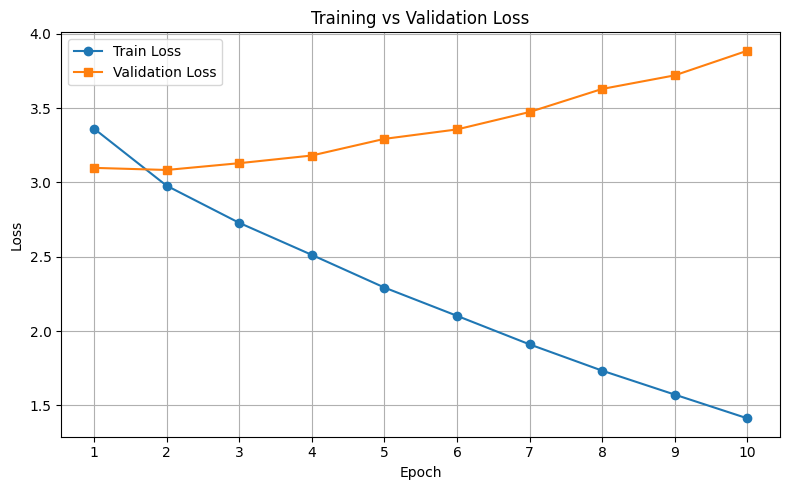

In [39]:
plot_loss_curves(train_loss_bart, val_loss_bart)


In [19]:
_, _, _, _, test_inputs, test_targets = load_arrow_data()

bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")

test_dataset_bart = CounselingDataset(test_inputs, test_targets, bart_tokenizer, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH)
test_loader_bart = DataLoader(test_dataset_bart, batch_size=BATCH_SIZE, shuffle=False)

test_dataset_t5 = CounselingDataset(test_inputs, test_targets, t5_tokenizer, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH)
test_loader_t5 = DataLoader(test_dataset_t5, batch_size=BATCH_SIZE, shuffle=False)

bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
bart_model.load_state_dict(torch.load("/kaggle/input/bart_model/pytorch/default/1/best_bartforconditionalgeneration_model.pt", map_location=DEVICE))

t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")
t5_model.load_state_dict(torch.load("/kaggle/input/bestt5_model/pytorch/default/1/best_t5forconditionalgeneration_model.pt", map_location=DEVICE))



Loading datasets...
Loaded 4008 samples from /kaggle/input/filedataset2/data/therapy_train
Loaded 576 samples from /kaggle/input/filedataset2/data/therapy_val
Loaded 968 samples from /kaggle/input/filedataset2/data/therapy_test

Sample training examples:

Input: T: Hi you how to do it today? [SEP] P: Great. How are you?
Target: I'm doing well. Thanks for asking.

Input: T: Hi you how to do it today? [SEP] P: Great. How are you? [SEP] T: I'm doing well. Thanks for asking.
Target: So you're doing great.

Input: T: Hi you how to do it today? [SEP] P: Great. How are you? [SEP] T: I'm doing well. Thanks for asking. [SEP] T: So you're doing great. [SEP] P: I'm doing awesome.
Target: I know your brother brought you in today and he had expressed some concerns about your mood. Do you know what that's about?


/tmp/ipykernel_31/4031295238.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bart_model.load_state_dict(torch.load("/kaggle/input/bart_model/pytorch/default/1/best_bart

<All keys matched successfully>

In [21]:
print("\nEvaluating T5 model...")
t5_preds, t5_refs, t5_bleu_scores, t5_bert_scores = generate_and_evaluate(t5_model, t5_tokenizer, test_loader_t5, "T5")
    

print("\nEvaluating BART model...")
bart_preds, bart_refs, bart_bleu_scores, bart_bert_scores = generate_and_evaluate(bart_model, bart_tokenizer,test_loader_bart, "BART")
    
# Compare models
t5_avg_bleu = sum(t5_bleu_scores) / len(t5_bleu_scores) if t5_bleu_scores else 0
bart_avg_bleu = sum(bart_bleu_scores) / len(bart_bleu_scores) if bart_bleu_scores else 0
    
t5_avg_bert_f1 = sum(t5_bert_scores['f1']) / len(t5_bert_scores['f1'])
bart_avg_bert_f1 = sum(bart_bert_scores['f1']) / len(bart_bert_scores['f1'])
    
print("\nModel Comparison:")
print(f"T5 Average BLEU score: {t5_avg_bleu:.4f}")
print(f"BART Average BLEU score: {bart_avg_bleu:.4f}")
print(f"T5 Average BERTScore F1: {t5_avg_bert_f1:.4f}")
print(f"BART Average BERTScore F1: {bart_avg_bert_f1:.4f}")
    
if t5_avg_bleu > bart_avg_bleu and t5_avg_bert_f1 > bart_avg_bert_f1:
    print("T5 model performed better according to both BLEU and BERTScore")
elif bart_avg_bleu > t5_avg_bleu and bart_avg_bert_f1 > t5_avg_bert_f1:
    print("BART model performed better according to both BLEU and BERTScore")
else:
    print("Models show mixed performance - consider both metrics")


Evaluating T5 model...


Generating predictions with T5: 100%|██████████| 121/121 [01:17<00:00,  1.57it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



T5 Results:
Average BLEU score: 0.0186
Average BERTScore Precision: 0.8611
Average BERTScore Recall: 0.8443
Average BERTScore F1: 0.8524

Example 1:
Reference: Are you evaluated at work by anybody to see if you're in a job you should be?
Prediction: Okay, let's take a step back and talk about competency. Okay, let's take a step back and talk about competency.
BLEU score: 0.0073
BERTScore F1: 0.8334

Example 2:
Reference: Have you been Found in that system to be somebody who's satisfying the requirements of in terms of competency satisfy the requirements of employee.
Prediction: Okay, so that's what we're talking about. Okay, so let's take a step back and talk about competency. So let's take a step back and talk about competency.
BLEU score: 0.0071
BERTScore F1: 0.8458

Evaluating BART model...


Generating predictions with BART: 100%|██████████| 121/121 [01:01<00:00,  1.96it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BART Results:
Average BLEU score: 0.0219
Average BERTScore Precision: 0.8648
Average BERTScore Recall: 0.8488
Average BERTScore F1: 0.8564

Example 1:
Reference: Are you evaluated at work by anybody to see if you're in a job you should be?
Prediction: Okay, so you have a bachelor's degree.
BLEU score: 0.0102
BERTScore F1: 0.8581

Example 2:
Reference: Have you been Found in that system to be somebody who's satisfying the requirements of in terms of competency satisfy the requirements of employee.
Prediction: Okay, so you have a supervisor that you can go to.
BLEU score: 0.0085
BERTScore F1: 0.8607

Model Comparison:
T5 Average BLEU score: 0.0186
BART Average BLEU score: 0.0219
T5 Average BERTScore F1: 0.8524
BART Average BERTScore F1: 0.8564
BART model performed better according to both BLEU and BERTScore
